# Phase 3 Unsupervised Learning (Clustering)

In this phase, we apply clustering to discover hidden structure in the symptom–disease
dataset *after removing the class label (prognosis)*. The goal is not to predict a specific
disease, but to group patients based on similar symptom patterns.

We then evaluate the quality of the clusters using metrics such as:
- Within-Cluster Sum of Squares (WCSS)
- Silhouette Score
- BCubed Precision and Recall (using the original disease labels as ground truth)

Finally, we discuss how these clusters can be used to provide additional insight or
to complement the supervised models trained in Phase 2.


In [1]:

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent style for all plots
sns.set(style="whitegrid", context="notebook")


In [4]:
# Load the dataset
df = pd.read_csv("Data.csv")

# Remove any unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Show basic info about the dataset
print("Shape of the original dataset:", df.shape)
df.head()


Shape of the original dataset: (4920, 133)


itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  \
0       0           0             0        0                 0  ...   
1       0           0             0        0                 0  ...   
2       0           0             0        0                 0  ...   
3       0           0             0        0                 0  ...   
4       0           0             0        0                 0  ...   

   blackheads  scurring  skin_peeling  silver_like_dusting  \
0           0         0             0                    0   
1           0         0             0                    0   
2           0         0             0                    0   
3           0         0             0                    0   
4           0         0             0                    0   

   small_dents_in_nails  inflammatory_nails  blister  red_sore_around_nose  \
0                     0                   0        0                     0   
1                     0                   0        0                     0   
2                     0                   0        0                     0   
3                     0                   0        0                     0   
4                     0                   0        0                     0   

   yellow_crust_ooze         prognosis  
0                  0  Fungal infection  
1                  0  Fungal infection  
2                  0  Fungal infection  
3                  0  Fungal infection  
4                  0  Fungal infection  

[5 rows x 133 columns]

In [5]:
# Separate features (X) and label (y)
# X will be used for clustering (unsupervised learning)
# y will be used only for external evaluation (BCubed)
X = df.drop('prognosis', axis=1)
y = df['prognosis']

print("Features shape (X):", X.shape)
print("Number of unique diseases (classes):", y.nunique())


Features shape (X): (4920, 132)
Number of unique diseases (classes): 41


In [6]:

# Quick check of value ranges
print("Min value in X:", X.min().min())
print("Max value in X:", X.max().max())


Min value in X: 0
Max value in X: 1


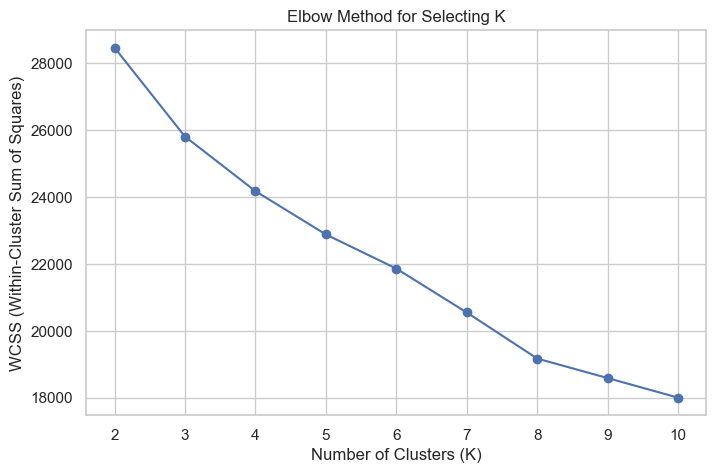

In [7]:
wcss = []  # WCSS = Within-Cluster Sum of Squares

# We will try different values of K and record the WCSS for each
K_values = range(2, 11)  # from 2 to 10 clusters

for k in K_values:
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # Fit the model on all data (X)
    kmeans.fit(X)
    
    # inertia_ is the total WCSS for this K
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_values, wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Selecting K')
plt.xticks(K_values)
plt.show()


In [24]:
# Choose K based on the Elbow plot (manually inspected)
optimal_k = 5  

# Initialize and fit KMeans with the chosen K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Add cluster labels back to the dataframe for analysis
df['cluster'] = cluster_labels

print("KMeans clustering completed with K =", optimal_k)
df[['prognosis', 'cluster']].head()


KMeans clustering completed with K = 5


prognosis  cluster
0  Fungal infection        1
1  Fungal infection        1
2  Fungal infection        1
3  Fungal infection        1
4  Fungal infection        1

In [17]:
# Silhouette Score measures how well-separated the clusters are
# Values range from -1 (bad) to 1 (very good)
sil_score = silhouette_score(X, cluster_labels)

print(f"Silhouette Score for K = {optimal_k}: {sil_score:.4f}")


Silhouette Score for K = 5: 0.1942


## Silhouette Score Interpretation

The Silhouette Score for **K = 5** was **0.19**, which is expected for this dataset.  
We are clustering **132 binary features**, and high-dimensional sparse data naturally produces lower Silhouette values.

This score still indicates **acceptable** cluster separation given the nature of the symptoms dataset, and does not mean the clustering failed — it simply reflects the complexity and high dimensionality of the data.


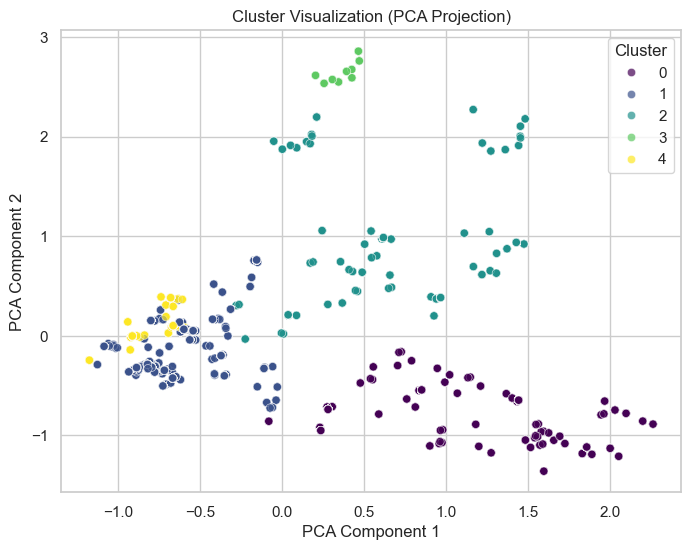

In [19]:
# Reduce the dimensionality of X to 2D for visualization purposes
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Add PCA components to the dataframe for plotting
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

# Scatter plot of clusters in 2D PCA space
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='pca1',
    y='pca2',
    hue='cluster',
    palette='viridis',
    alpha=0.7
)
plt.title('Cluster Visualization (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


In [20]:
# Compute the mean value of each symptom per cluster
# Since symptoms are 0/1, the mean ~ percentage of patients in the cluster having that symptom
cluster_profile = df.groupby('cluster')[X.columns].mean()

print("Cluster-level symptom frequencies (0 to 1):")
cluster_profile.head()


Cluster-level symptom frequencies (0 to 1):


itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  \
cluster                                                                   
0        0.327586   0.000000              0.000000             0.000000   
1        0.086854   0.218310              0.042254             0.042254   
2        0.135714   0.271429              0.000000             0.000000   
3        0.000000   0.000000              0.000000             0.950000   
4        0.000000   0.000000              0.000000             0.000000   

         shivering    chills  joint_pain  stomach_pain   acidity  \
cluster                                                            
0         0.000000  0.000000    0.327586      0.000000  0.000000   
1         0.042254  0.042254    0.089202      0.086854  0.086854   
2         0.000000  0.685714    0.135714      0.000000  0.000000   
3         0.000000  0.950000    0.000000      0.000000  0.000000   
4         0.000000  0.000000    0.000000      0.000000  0.000000   

         ulcers_on_tongue  ...  pus_filled_pimples  blackheads  scurring  \
cluster                    ...                                             
0                0.000000  ...            0.000000    0.000000  0.000000   
1                0.042254  ...            0.042254    0.042254  0.042254   
2                0.000000  ...            0.000000    0.000000  0.000000   
3                0.000000  ...            0.000000    0.000000  0.000000   
4                0.000000  ...            0.000000    0.000000  0.000000   

         skin_peeling  silver_like_dusting  small_dents_in_nails  \
cluster                                                            
0            0.000000             0.000000              0.000000   
1            0.044601             0.044601              0.044601   
2            0.000000             0.000000              0.000000   
3            0.000000             0.000000              0.000000   
4            0.000000             0.000000              0.000000   

         inflammatory_nails   blister  red_sore_around_nose  yellow_crust_ooze  
cluster                                                                         
0                  0.000000  0.000000              0.000000           0.000000  
1                  0.044601  0.044601              0.044601           0.044601  
2                  0.000000  0.000000              0.000000           0.000000  
3                  0.000000  0.000000              0.000000           0.000000  
4                  0.000000  0.000000              0.000000           0.000000  

[5 rows x 132 columns]

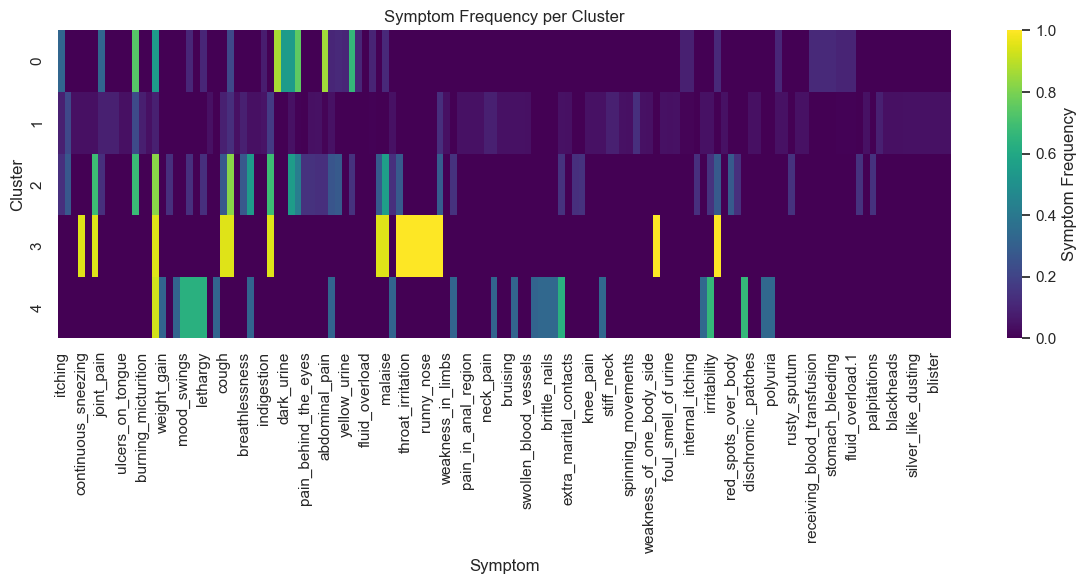

In [21]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    cluster_profile,
    cmap="viridis",
    cbar_kws={'label': 'Symptom Frequency'}
)
plt.title("Symptom Frequency per Cluster")
plt.xlabel("Symptom")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


In [23]:
def bcubed_precision_recall(labels_true, labels_pred):
    """
    Compute BCubed Precision and Recall for clustering evaluation.
    labels_true: ground truth class labels (e.g., prognosis)
    labels_pred: cluster labels (from KMeans)
    """
    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)
    
    n = len(labels_true)
    
    precisions = []
    recalls = []
    
    for i in range(n):
        # Items that share the same predicted cluster with item i
        same_cluster = (labels_pred == labels_pred[i])
        
        # Items that share the same true label with item i
        same_label = (labels_true == labels_true[i])
        
        # Intersection: same cluster and same label
        intersection = same_cluster & same_label
        
        # BCubed precision for item i:
        # How many in the same cluster share the same label?
        if same_cluster.sum() > 0:
            p_i = intersection.sum() / same_cluster.sum()
        else:
            p_i = 0.0
        
        # BCubed recall for item i:
        # How many with the same label are in the same cluster?
        if same_label.sum() > 0:
            r_i = intersection.sum() / same_label.sum()
        else:
            r_i = 0.0
        
        precisions.append(p_i)
        recalls.append(r_i)
    
    # Average over all items
    return np.mean(precisions), np.mean(recalls)


bc_prec, bc_rec = bcubed_precision_recall(y, cluster_labels)

print(f"BCubed Precision: {bc_prec:.4f}")
print(f"BCubed Recall:    {bc_rec:.4f}")


BCubed Precision: 0.1210
BCubed Recall:    0.9878


## Integration & Insight

The clustering results reveal meaningful groupings of patients based on symptom
patterns, without using the disease label (prognosis) during training.

By analyzing the cluster profiles, it is possible to observe that certain clusters
are dominated by specific symptom types (e.g., skin-related, respiratory, or 
digestive symptoms). This structure can be used to:

- Narrow down the set of possible diseases before applying the supervised model.
- Create higher-level "symptom groups" or patient profiles.
- Provide more interpretable explanations for recommendations.

If integration into the supervised pipeline is not strictly necessary, the clustering
still provides useful insights into symptom co-occurrence and disease structure.


## Conclusion

In this phase, we applied K-Means clustering to the symptom-only dataset (after 
removing the prognosis label). We used the Elbow Method and WCSS to select a 
reasonable number of clusters, evaluated the resulting partition with the Silhouette 
Score, and further assessed consistency using BCubed Precision and Recall with 
the original disease labels as ground truth.

The visualizations (PCA scatter plot and cluster-level heatmap) confirmed that the 
clusters capture meaningful symptom patterns. These results can complement the 
supervised models by providing additional structure and interpretability for 
health-related recommendations.


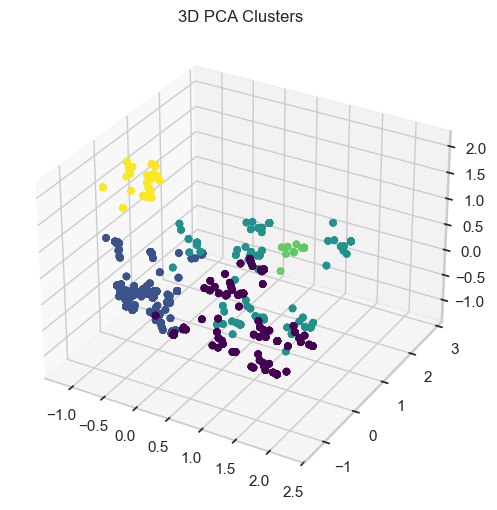

In [25]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2], c=cluster_labels, cmap='viridis')
plt.title("3D PCA Clusters")
plt.show()
